#                                           **MEDICAL DIAGNOSIS OF PNEUMONIA USING CHEST-XRAY**

### **Uploading "kaggle apk" file into Google colab**



In [ ]:
from google.colab import files
files.upload()

### **Making directory of kaggle in Google colab**

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

### **Downloading "Pneumonia" Dataset from kaggle**

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:29<00:00, 17.7MB/s]
100% 2.29G/2.29G [00:30<00:00, 81.8MB/s]


### **Extracting whole data from chest-xray zip file**

In [ ]:
from zipfile import ZipFile
file_name="chest-xray-pneumonia.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


### **Importing all necessary libraries**

In [ ]:
import os
import glob
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

#configure random transformations and normalization operations to be done on your image data during training
#instantiate generators of augmented image batches (and their labels) via .flow_from_directory(directory).
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import to_categorical

### **Taking Input data from directory**

In [ ]:
training_dir = './chest_xray/train'
validation_dir = './chest_xray/val'
test_dir = './chest_xray/test'

###  **Visualizing the Data**

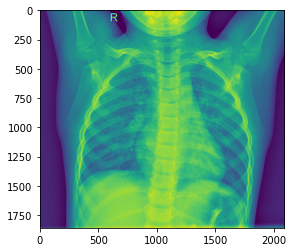

In [ ]:
img = mpimg.imread(training_dir + '/NORMAL/IM-0115-0001.jpeg')
imgplot = plt.imshow(img)
plt.show()

### **Preprocessing the Data [Image Preprocessing]**

In [ ]:
def plot_images(path, labeled=False, max_images=6):
    amount = 0
    fig = plt.figure(figsize=(10, 6))

    for file in os.listdir(path):
        if file.endswith('.jpeg'):
            if amount == max_images:
                break

            img = mpimg.imread(os.path.join(path, file))
            plt.subplot(231+amount)
            if labeled:
                plt.title(file.split('_')[1])
            imgplot = plt.imshow(img)

            amount += 1

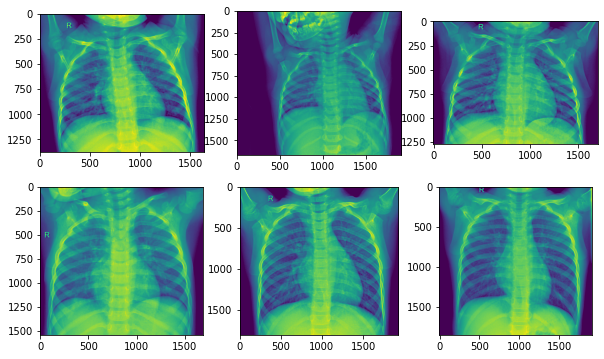

In [ ]:
plot_images(training_dir + '/NORMAL')

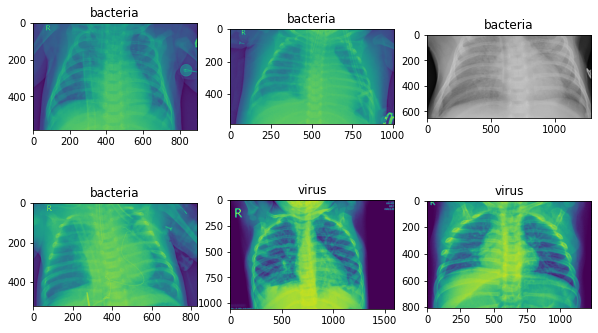

In [ ]:
plot_images(training_dir + '/PNEUMONIA', labeled=True)

### **Data Augmentation**

*   In order to make the most of our few training examples, we will "augment" them via a number of random transformations, so that our model would never see twice the exact same picture. This helps prevent overfitting and helps the model generalize better.




In [ ]:
train_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=training_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 10)

valid_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=validation_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 10)

test_batches = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(directory=test_dir, target_size=(224,224), classes=['NORMAL','PNEUMONIA'],batch_size = 1, shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### **Fine Tuned Model VGG19**

In [ ]:
vgg19_model = VGG19()  #Downloading the VGG19 model

In [ ]:
vgg19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

###  **Here Creating the model similar to VGG19 by leaving the last layer of VGG19 model because it consists of more than 1000 classes.But we required only two classes[Pneumonia,Normal]**

In [ ]:
model = Sequential()
for layer in vgg19_model.layers[:-1]:
    model.add(layer)

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

In [ ]:
# Don't train existing weights
for layer in model.layers:
    layer.trainable = False

In [ ]:
# our layers-you can add more if you want
model.add(Dense(2, activation = 'softmax')) # adding a dense layer at the output with softmax activation

In [ ]:
#It helps to view the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)      

### **Train the fine-tuned VGG19 Model**

In [ ]:
# Tell the model what cost and optimization method to use
model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
history = model.fit(x = train_batches, validation_data = valid_batches, epochs = 2, verbose = 1)

Epoch 1/2
522/522 [==============================] - 65s 124ms/step - loss: 0.2097 - accuracy: 0.9143 - val_loss: 0.3082 - val_accuracy: 0.9375
Epoch 2/2
522/522 [==============================] - 64s 123ms/step - loss: 0.1169 - accuracy: 0.9526 - val_loss: 0.3226 - val_accuracy: 0.9375


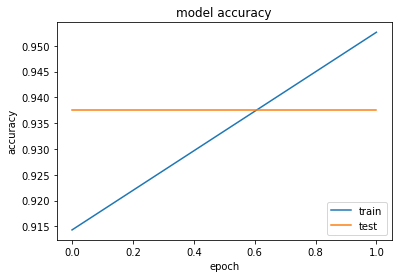

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

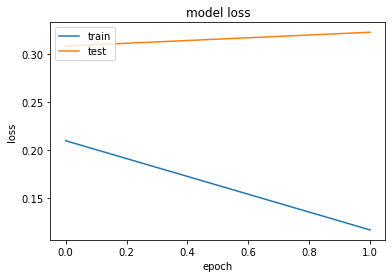

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### **Evaluate the trained fine-tuned VGG19 model**

In [ ]:
result  = model.evaluate(test_batches, steps=len(test_batches), verbose=1)
print('Loss:', result[0])
print('Accuracy:', result[1])

624/624 [==============================] - 10s 17ms/step - loss: 0.5289 - accuracy: 0.7885
Loss: 0.5288872122764587
Accuracy: 0.7884615659713745


In [ ]:
# Predicting the model against test batches
predictions = model.predict(x = test_batches, verbose = 0)

### **Confusion Matrix**

In [ ]:
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))

In [ ]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion matrix')
    else:
        print('Confusion matrix without normalization')
    
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j], horizontalalignment="center", color = "white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix without normalization
[[104 130]
 [  2 388]]


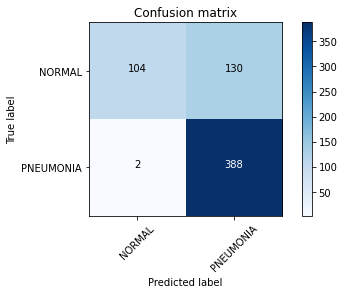

In [ ]:
cm_plot_labels = ['NORMAL', 'PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion matrix")

In [ ]:
y_pred_batches = []
y_true_batches = []
y_img_batches = []

for i in range(0, len(test_batches)):
    y_img_batch, y_true_batch = test_batches[i]
    y_true_batch = y_true_batch.argmax(axis=-1)
    y_img_batches.append(y_img_batch)
    y_true_batches.append(y_true_batch)

    y_pred_batch = model.predict(y_img_batch)
    y_pred_batch = y_pred_batch.argmax(axis=-1)
    y_pred_batches.append(y_pred_batch)



In [ ]:
yimg, ytrue = test_batches[0]
ypred = model.predict(yimg)
print(ypred)

[[0.51900357 0.4809964 ]]


### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(y_true_batches, y_pred_batches, target_names=target_names))

              precision    recall  f1-score   support

      NORMAL       0.98      0.44      0.61       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.87      0.72      0.73       624
weighted avg       0.84      0.79      0.76       624



In [ ]:
def predict_images(images_path, label):
    amount = 0
    fig = plt.figure(figsize=(18, 8))

    for file in os.listdir(images_path):
        if file.endswith('.jpeg'):
            if amount == 8:
                break

        img = mpimg.imread(os.path.join(images_path, file))
        plt.subplot(241+amount)
        plt.title('{} ---- {}'.format(label, 'NORMAL' if y_pred_batches[amount] == 0 else 'PNEUMONIA'))
        imgplot = plt.imshow(img)

        amount += 1

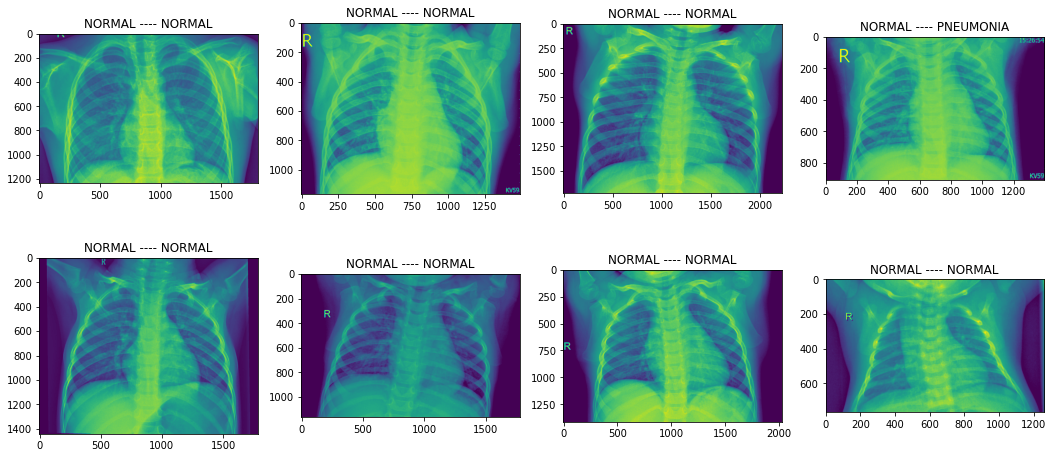

In [ ]:
predict_images(test_dir +'/NORMAL', 'NORMAL')

### **Save the trained model in a particular file for further use**

In [ ]:
model.save('PneumoniaDetection_model.h5')

In [ ]:
! pwd

/content


### **Installing necessary Libraries**

In [ ]:
! pip install httplib2==0.15.0

! pip install google-api-python-client==1.6

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials

### **Here we must provide Google authentication for accessing the Saved file**

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()                       
drive = GoogleDrive(gauth)

### **Uploading the saved file into Drive**

In [ ]:
model.save('PneumoniaDetection_model.h5')
model_file = drive.CreateFile({'title' : 'PneumoniaDetection_model.h5'})                       
model_file.SetContentFile('PneumoniaDetection_model.h5')                       
model_file.Upload()

In [ ]:
drive.CreateFile({'id': model_file.get('id')})

GoogleDriveFile({'id': '12HD6qTvZRmo0gpfik1cFi3609L4DbXxW'})

### **Read the pre-trained model for evaluaing**

In [ ]:
new_model = load_model('PneumoniaDetection_model.h5')

In [ ]:
yimg, ytrue = test_batches[2]
ypred = new_model.predict(yimg)
print(ypred)

[[0.76042277 0.23957726]]
